7/7 [==============================] - 2s 25ms/step

📊 Stock Market Summary
🔹 Latest Closing Price: $245.83
🔹 Possible Bullish Price (Upper 95% Prediction): $422.24
🔹 Possible Bearish Price (Lower 95% Prediction): $178.24
🔹 Market Cap: N/A
🔹 P/E Ratio: N/A
🔹 Dividend Yield: N/A
🔹 52-Week High: 259.02
🔹 52-Week Low: 116.36
🔹 Value at Risk (95% Confidence): -2.70%
🔹 Sortino Ratio: 1.15
🔹 Max Drawdown: -31.31%
🤖 Rule-Based Trading Decision: HOLD


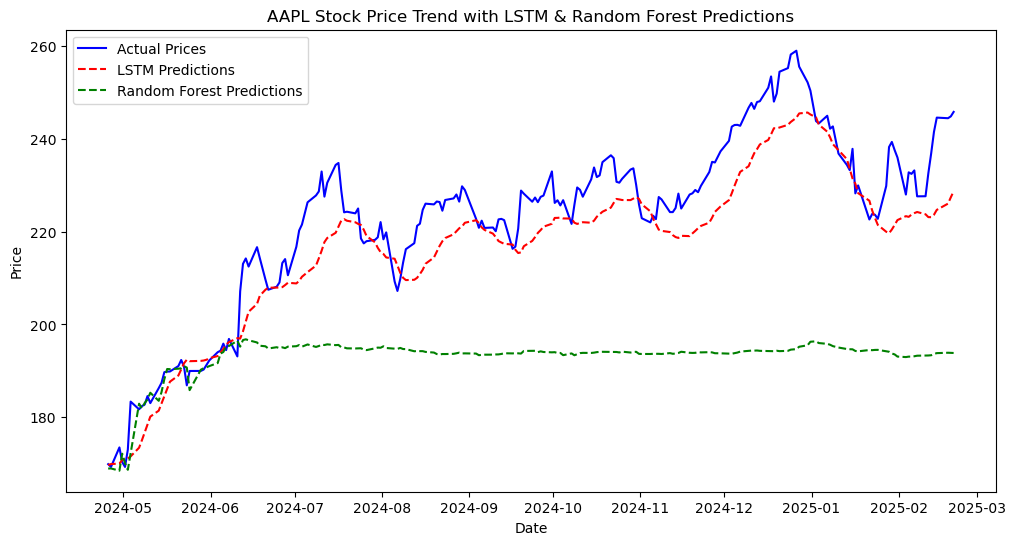

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import ta

# --- Data Loading and Preprocessing ---
def load_and_preprocess_data(file_path):
    try:
        stock_data = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None

    # Calculate technical indicators
    stock_data['RSI'] = ta.momentum.RSIIndicator(stock_data['Close']).rsi()
    stock_data['MACD'] = ta.trend.MACD(stock_data['Close']).macd()
    stock_data['MA_50'] = stock_data['Close'].rolling(window=50).mean()
    stock_data['MA_200'] = stock_data['Close'].rolling(window=200).mean()
    stock_data.dropna(inplace=True)
    return stock_data

# --- Risk Analysis ---
def calculate_risk_metrics(returns, confidence_level=0.95):
    # Value at Risk (using the 5th percentile if confidence_level is 95%)
    var_95 = np.percentile(returns, (1 - confidence_level) * 100)
    # Sortino Ratio: Annualized (assuming 252 trading days)
    downside_returns = returns[returns < 0]
    sortino_ratio = (returns.mean() * 252) / (downside_returns.std() * np.sqrt(252))
    
    # Calculate cumulative returns, rolling max, and drawdown
    cumulative_returns = (1 + returns).cumprod()
    rolling_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - rolling_max) / rolling_max
    max_drawdown = drawdown.min()
    
    return var_95, sortino_ratio, max_drawdown

# --- Monte Carlo Simulation ---
def monte_carlo_simulation(returns, current_price, simulations=1000, days=180):
    simulated_prices = []
    for _ in range(simulations):
        daily_returns = np.random.normal(returns.mean(), returns.std(), days)
        # Calculate the cumulative growth factor and convert to a future price prediction
        future_growth_factor = (1 + daily_returns).cumprod()[-1]
        future_price = current_price * future_growth_factor
        simulated_prices.append(future_price)
    upper_95 = np.percentile(simulated_prices, 97.5)
    lower_95 = np.percentile(simulated_prices, 2.5)
    return upper_95, lower_95

# --- Trading Strategy ---
def trading_signal(rsi, macd):
    if rsi < 30 and macd > 0:
        return "BUY"
    elif rsi > 70 and macd < 0:
        return "SELL"
    else:
        return "HOLD"

# --- Model Training and Prediction ---
def train_and_predict(stock_data, sequence_length=30):
    scaler = MinMaxScaler()
    # Scale the features
    scaled_data = scaler.fit_transform(stock_data[['Close', 'RSI', 'MACD', 'MA_50', 'MA_200']])
    
    X, y = [], []
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i - sequence_length:i])
        y.append(scaled_data[i, 0])  # Target: Close price
    X, y = np.array(X), np.array(y)
    
    # Train-Test Split (80/20)
    train_size = int(0.8 * len(X))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # Build and train LSTM model
    model_lstm = Sequential([
        Bidirectional(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))),
        Dropout(0.2),
        Bidirectional(LSTM(50, return_sequences=False)),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)
    ])
    model_lstm.compile(optimizer='adam', loss='mean_squared_error')
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model_lstm.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=0)
    
    # Predict with LSTM and convert predictions back to original scale
    y_pred_lstm = model_lstm.predict(X_test)
    y_pred_actual_lstm = scaler.inverse_transform(np.column_stack([y_pred_lstm, np.zeros((y_pred_lstm.shape[0], 4))]))[:, 0]
    
    # Train and predict with Random Forest
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train.reshape(len(X_train), -1), y_train)
    y_pred_rf = rf_model.predict(X_test.reshape(len(X_test), -1))
    y_pred_actual_rf = scaler.inverse_transform(np.column_stack([y_pred_rf, np.zeros((y_pred_rf.shape[0], 4))]))[:, 0]
    y_test_actual = scaler.inverse_transform(np.column_stack([y_test, np.zeros((y_test.shape[0], 4))]))[:, 0]
    
    return y_test_actual, y_pred_actual_lstm, y_pred_actual_rf

# --- Main Execution ---
csv_file_path = r"C:\Users\angel\Downloads\AAPL_5year.csv"
stock_data = load_and_preprocess_data(csv_file_path)

if stock_data is not None:
    # Basic market metrics
    latest_price = stock_data['Close'].iloc[-1]
    week_high = stock_data['Close'].max()
    week_low = stock_data['Close'].min()
    market_cap = "N/A"
    p_e_ratio = "N/A"
    div_yield = "N/A"

    # Calculate risk metrics
    returns = stock_data['Close'].pct_change().dropna()
    var_95, sortino_ratio, max_drawdown = calculate_risk_metrics(returns)
    
    # Monte Carlo simulation (with the latest price as the starting point)
    upper_95, lower_95 = monte_carlo_simulation(returns, latest_price)

    # Trading decision based on latest technical indicators
    latest_rsi = stock_data['RSI'].iloc[-1]
    latest_macd = stock_data['MACD'].iloc[-1]
    trade_decision = trading_signal(latest_rsi, latest_macd)

    # Train models and obtain predictions
    y_test_actual, y_pred_actual_lstm, y_pred_actual_rf = train_and_predict(stock_data)

    # --- Print Stock Market Summary ---
    print("\n📊 Stock Market Summary")
    print(f"🔹 Latest Closing Price: ${latest_price:.2f}")
    print(f"🔹 Possible Bullish Price (Upper 95% Prediction): ${upper_95:.2f}")
    print(f"🔹 Possible Bearish Price (Lower 95% Prediction): ${lower_95:.2f}")
    print(f"🔹 Market Cap: {market_cap}")
    print(f"🔹 P/E Ratio: {p_e_ratio}")
    print(f"🔹 Dividend Yield: {div_yield}")
    print(f"🔹 52-Week High: {week_high:.2f}")
    print(f"🔹 52-Week Low: {week_low:.2f}")
    print(f"🔹 Value at Risk (95% Confidence): {var_95:.2%}")
    print(f"🔹 Sortino Ratio: {sortino_ratio:.2f}")
    print(f"🔹 Max Drawdown: {max_drawdown:.2%}")
    print(f"🤖 Rule-Based Trading Decision: {trade_decision}")

    # --- Graph: Stock Price Trend, LSTM Predictions & Random Forest Predictions ---
    plt.figure(figsize=(12, 6))
    plt.plot(stock_data.index[-len(y_test_actual):], y_test_actual, label="Actual Prices", color='blue')
    plt.plot(stock_data.index[-len(y_pred_actual_lstm):], y_pred_actual_lstm, label="LSTM Predictions", color='red', linestyle='dashed')
    plt.plot(stock_data.index[-len(y_pred_actual_rf):], y_pred_actual_rf, label="Random Forest Predictions", color='green', linestyle='dashed')
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title("AAPL Stock Price Trend with LSTM & Random Forest Predictions")
    plt.legend()
    plt.show()